# Coursework 2: Data Processing

## Task 1
This coursework will assess your understanding of using NoSQL to store and retrieve data.  You will perform operations on data from a collection of scientific articles in a MongoDB database.  You will be required to run code to answer the given questions in the Jupyter notebook provided.


Download the dataset articles.json from Blackboard and import it into a collection called 'articles' into the 'coursework' database. The Virtual Machine comes pre-configured with an user "coursework" with password "coursework" with read-write privileges over the coursework database. The admin database is also 'coursework'. 

Each question asks you to implement a function following a certain specification. We have an evaluation script that will check the correctness of your answer. It is essential that:
 
 1. You respect the requested answer format, otherwise, the script will flag your answer as incorrect. If the result is correct, but your formatting is incorrect, you get a penalty of -20% of the mark.
 
 2. Do not insert or delete cells in the notebook you will submit, the evaluation script relies on your answer being in the right cell.
    
    1. If you feel the need of inserting cells to prepare and test your answer, do it in a copy of the notebook. Once you finish an answer that fits in a single cell, transfer it to the notebook that you will submit.
    
    2. You can define auxiliary functions if you want, as long as they are all in the same cell as the main function.
    
    3. If you add print statements for testing, please delete or comment them before submitting.


Answers can make use of the tools you learned so far: MongoDB pipelines and operators, Python code, pandas and networkx. An important aspect of the coursework is to identify in what situations is best to use MongoDB only, and in what situations is best to use multiple tools. A bad choice may make your answer less efficient, and in some cases, not run at all. The marking scheme at the end of the notebook details the expected execution times of your answers. Less efficient answers will get less marks.



 ## Context
    
Bibliometrics Ltd. has hired you, dear data scientist, to analyse the latest articles in Computer Science collected by the DBLP (https://dblp.uni-trier.de/) open bibliographic service and further processed by the AMiner team (https://www.aminer.cn/citation). You have been provided with the articles from 2017 and 2019 and an MS Teams chat window with "The Management", on which you will get the questions you need to answer. 

In [1]:
#import section
import pymongo
from pymongo import MongoClient
from datetime import datetime
from pprint import pprint
import networkx as nx
import pandas as pd

### 0) 

Before the first question pops in the chat window, you better off set up everything to provide answers.

Task:

Write a function that given the name of a database and the name of a collection returns a pymongo collection object of the collection using the user you just created. Use this function to create a pymongo collection object of the 'articles' collection.


[5 points]

In [2]:
def get_collection(dbname,collection_name):
    """
    Connects to the server, and returns a collection object
    of the `collection_name` collection in the `dbname` database
    """
    client = MongoClient('mongodb://' + dbname + ':' + dbname + '@localhost:27017', authSource=dbname)
    db = client[dbname]
    return db, db[collection_name]

# the collection on which you will work on
db, articles = get_collection('coursework','articles')




### 1) 

The Management has logged in... they want to know how many articles of each type according to the 'doc_type' property are in the dataset. However, being the competent data scientist you are, you know that you always need to verify your data before start crunching numbers...

### Task:

Write a function that returns the number of articles missing the 'doc_type' property or having it equal to the empty string ("") 

[5 points] 



In [3]:
def count_missing_doc_types(articles):
    """
    :param articles A PyMongo collection of articles
    :return: int: Number or articles without a a 'doc_type' property or having it equal to the empty string ('') 
    """
    # YOUR CODE HERE
    match = {
        "$match": {
            "$or":[
            {"doc_type":""},
            {"doc_type":{ "$exists": False }}
          ]
        }
    }

    group = {
        '$group': {'_id': None, 'count': {'$sum': 1}}
    }

    cursor = articles.aggregate([match, group])
    count = 0
    for c in cursor:
        count = c['count']
    return count

### 2) 

You inform The Management of how many articles are missing the doc_type property or have it empty. They would like to fix as many as possible before moving forward. They may be able to infer the missing types based on the article publisher, so they ask: what are the publishers of the articles that are missing the doc_type property?

### Task:

Write a function that returns the set of publishers of articles that are missing the doc_type property or have it equal to the empty string. 

[5 points]

In [4]:
def get_publishers_of_articles_missing_type(articles):
    """
    :param articles PyMongo collection of articles
    :return: Set: set of publishers of articles that are missing the doc_type property, defined as not having the field at all, or having it equal to the empty string.
    """    
    
    match = {
        "$match": {
            "$or":[
            {"doc_type":""},
            {"doc_type":{ "$exists": False }}
          ]
        }
    }

    group = {
        '$group': {'_id': '$publisher', 'count': {'$sum': 1}}
    }
    
    cursor = articles.aggregate([match, group])
    st = set()
    for c in cursor:
        st.add(c['_id'])
    return st

### 3)

The Management analysed the set you provided in the previous task and decided that:

 1) Articles missing doc_type  with publisher == 'Springer, Cham' should have 'doc_type' == 'Book'
 
 2) Articles missing doc_type with publisher  == 'RFC Editor' should have 'doc_type' == 'RFC'
 
 3) The remainder of articles missing doc_type should have 'doc_type' == 'N/A'
 
Task:

Write a function that updates the article collection according to The Management's decision.

[5 points]

In [5]:
def update_doc_types(articles):
    """
    :param articles: PyMongo collection of articles
    :return: PyMongo UpdateResult object 
    """    
    # YOUR CODE HERE
    
    newvalues = { "$set": { "doc_type": "Book" } }
    filter = {"$and": [{"$or": [{"doc_type": { "$exists": False }}, {'doc_type':''}]}, {'publisher': 'Springer, Cham'}]}
    articles.update_many(filter, newvalues)
    
    newvalues = { "$set": { "doc_type": "RFC" } }
    filter = {"$and": [{"$or": [{"doc_type": { "$exists": False }}, {'doc_type':''}]}, {'publisher': 'RFC Editor'}]}
    articles.update_many(filter, newvalues)
    
    filter = {"$or": [{"doc_type": { "$exists": False }}, {'doc_type':''}]}
    
    newvalues = { "$set": { "doc_type": "N/A" } }
    articles.update_many(filter, newvalues)
    

### 4)

You are finally ready to answer the original question: What is the distribution of document types in the dataset?

Task:

Write a function that returns a dictionary with doc_types as keys and the number of articles of each type as values.

e.g:

{'Conference' : 4566 , 'N/A' : 7992 ...}



[5 points]


In [6]:
def get_types_distribution(articles):
    """
    :param articles: PyMongo collection of articles
    :return: Dictionary with article types as keys, and number of articles of type as value
    """ 
    # YOUR CODE HERE
    
    group = {
    '$group': {'_id': '$doc_type', 'count': {'$sum': 1}}
    }
    
    cursor = articles.aggregate([group])
    
    dct = {}
    for c in cursor:
        dct[c['_id']] = c['count']

    return dct


###  5)

Do longer articles (in number of pages) have more references?

Task:

Return an histogram dictionary with the following specification:

{
"1-5" : Average references of articles between 1 and 5 pages inclusive

"6-10" : Average references of articles between 6 and 10 pages inclusive

"11-15" : Average references of articles between 11 and 15 pages inclusive

"16-20" : Average references of articles between 16 and 20 pages inclusive

"21-25" : Average references of articles between 21 and 25 pages inclusive

"26-30" : Average references of articles between 26 and 30 pages inclusive

">30" : Average references of articles with more than 30 pages
}

A fellow data scientist of your team has found that some articles have no 'references' field, while others have unusually large page numbers. The Management decides that for this task you should

* Ignore articles that are missing the 'references' field
* Ignore articles with page numbers greater than 6 digits
* Ignore articles with page numbers that cannot be parsed to integers (e.g. 900467-12)
* Remember articles that start and end at the same page have 1 page, not zero!


[10 points]


In [7]:

def length_vs_references(articles):
    """
    :param collection A PyMongo collection object
    :return dictionary in the form described above
    """    
    pageReg = {
        '$addFields': {
          'resultObject': {

              "$and": [
              {
                '$regexMatch': {
                'input': "$page_start",
                'regex': '^[0-9]{1,6}$',
                'options': "m"
                }
              },
              {
                '$regexMatch': {
                'input': "$page_end",
                'regex': '^[0-9]{1,6}$',
                'options': "m"
                }
              }
            ]
          }
        }
      }



    match = {
            "$match": {
                "resultObject": True,
                  "references": {
                      "$exists": True
                  }
            }
        }

    # Define stage to set converted values
    toIntStage = {
       '$set': {
          'page_start': { '$toInt': "$page_start"},
          'page_end': { '$toInt': "$page_end"},
       }
    }


    # Define stage to calculate number of pages by subtracting
    calculationStage = {
       '$project': { 'doc_type': 1, 'numberOfRef': {'$size': "$references"},
                    'pages': {
                        '$add' : [{'$subtract': [ "$page_end", "$page_start" ]}, 1]
                   } 
            }
    }
    
    
    
    bucket = {
            '$bucket': {
              'groupBy': "$pages",
              'boundaries': [ 1, 6, 11, 16, 21, 26, 31 ], 
              'default': ">30",
                'output': {
                        "average": {
                            "$avg": "$numberOfRef"
                        }
                }
            }
        }
    
    project = {
        '$project': {
            '_id': 1,
            'average': {
                '$round': ['$average', 3]
            }
        }
    }
    

    cursor = articles.aggregate([pageReg, match, toIntStage, calculationStage, bucket, project])

    hist = {}

    for c in cursor:
        try:
            hist[str(c['_id']) + "-" + str(c['_id'] + 4)] = c['average']
        except:
            hist[c['_id']] = c['average']
            
    return hist


###  6)

Being the competent data scientist you are, you remember that before sending the results to The Management you  should be verify that they are meaningful and not affected by data quality. Can you trust these averages are not affected by outliers?

Task:

Write a function to return for each article length range a list of outliers, that is,  articles with a z-score of number of references greater or equal than 3 ((https://www.statisticshowto.com/probability-and-statistics/z-score/)) 

Note that we say "for each article length range", therefore, z-score needs to be computed using the mean and stdev  of the provided article lengths. For Standard Deviation in Mongo, use https://docs.mongodb.com/v4.4/reference/operator/aggregation/stdDevPop/

Example outpust is provided in a comment in the function

[10 points]


In [8]:
def get_reference_outliers(articles):
    """
    :param articles A PyMongo collection object
    :return Dictionary of the form described below:
     {"1-5" : {'outliers':[  
             {          
            id: article_id,           
            num_references: number of references,           
            z-score: z-score
          }, ... and so on...], 
     "6-10" : {'outliers':[  
             {          
            id: article_id,           
            num_references: number of references,           
            z-score: z-score
          }, ... and so on...] ,
    .... and so on.....
       }  
    """
    
    p1 = {
        '$project': {
            'result': {
                '$and': [
                    {
                        '$regexMatch': {
                            'input': "$page_start",
                            'regex': '^[0-9]{1,6}$',
                            'options': "m"
                        }
                    },{
                        '$regexMatch': {
                            'input': "$page_end",
                            'regex': '^[0-9]{1,6}$',
                            'options': "m"
                        }
                    }
                ]
            }, 
            'references': '$references',
            'page_start': '$page_start',
            'page_end': '$page_end',
            'id' : '$id'
        }
    }
    
    m1 = {'$match': {'references': { '$exists' : True}, 'result' : True }}
    
    p2 = {
        '$project': {
            'pages': {
                '$add': [{'$subtract': [{'$toLong': '$page_end'}, {'$toLong': '$page_start'}]}, 1]
            },
            'numberOfRef' : { '$size' : '$references'}, 
            'id' : '$id'
        }
    }
    
    bucketByRange = {
        '$bucket': {
            'groupBy': "$pages",
            'boundaries': [1, 6, 11, 16, 21, 26, 31],
            'default': ">30",
            'output': {
                'stddev': {
                    '$stdDevPop':'$numberOfRef'
                },
                'mean': {
                    '$avg': '$numberOfRef'
                },
                'articles': {
                    '$push': {
                        'id': '$id',
                        'numberOfRef': '$numberOfRef'
                    }
                }
            }
        }
    }
    
    u1= {
        '$unwind': '$articles'
    }
    
    p3 = {
        '$project': {
            '_id': 1, 
            'mean': '$mean', 
            'stdDev': '$stddev',
            'zscore': { 
                '$divide': [ {'$subtract': [{'$toInt': '$articles.numberOfRef'}, {'$toInt': '$mean'}]}, {'$toInt': '$stddev'}]
            },
            'numberOfRef' : '$articles.numberOfRef',
            'id' :'$articles.id'
        }
    }
    
    m2 = {'$match': {'zscore' : {'$gte' : 3}}}
    
    g1 = {
        '$group': {
            '_id': '$_id',
            'outliers': {
                '$push': { 
                    'id' : '$id',
                    'num_references': '$numberOfRef',
                    'z-score': { 
                        '$round': ['$zscore',3]
                    }
                }
            }
        }
    }
    
    sort = { 
        '$sort': {
            '_id': 1
        }
    }
    
    cursor = articles.aggregate([p1, m1, p2, bucketByRange, u1, p3, m2, g1, sort], allowDiskUse = True)
    
    hist = {
        "1-5": {},
        "6-10": {},
        "11-15": {},
        "16-20": {},
        "21-25": {},
        "26-30": {},
        ">30": {}
    }
    for c in cursor:
        try:
            hist[str(c['_id']) + '-' + str(c['_id'] + 4)]['outliers'] = c['outliers']
        except:
            hist[str(c['_id'])]['outliers'] = c['outliers']
            
    return hist


### 7) 

What are the collaborators of an author? 

Task:

Write a function that receives as input an author id and returns a list of authors that have at least one article co-authored with the input author. 
    
Notes:
* Assume authors are uniquely identified by their ids.
* Affiliations are in the 'org' field of the author subdocuments, you need to rename that field in your output to conform to the expected format.
* Sometimes affiliations come together in the same string value instead of different documents e.g. "University of Southampton and University of Bournemouth", consider this case as a single affiliation.
* Remember a dictionary does not have an ordering in its keys
* Some articles list authors only with name, without affiliation. Include this in your answer as a dictionary with a single key 'name'
* Example output is provided in the definition of the function


[8 points]




In [9]:

def get_collaborators(articles,author_id):
    """
    Input: articles: PyMongo collection of articles
        author_id : id of author
    Output: List of collaborators. 
    Example output:
    [
    {'id': 2942936634,  'names': [
           {'name': 'Lior Kovalio',
           'affiliation': 'The Hebrew Univ. of Jerusalem, Jerusalem, Israel'},
           {'name' : 'Lior Kovalio'}
           ]
    },
    {'id': 2231056490, 'names': [
           {'name': 'Gustavo F. Tondello', 
           'affiliation': 'University of Waterloo'},
           { 'name': 'Gustavo F. Tondello', 
           'affiliation': 'Federal University of Santa Catarina'}
           ]
    },
    {'id': 19031441 , 'names': [
                  {'affiliation': 'Hebrew University of Jerusalem, Israel / '
                            'Microsoft Research, Israel#TAB#',    
                    'name': 'Noam Nisan'},
                   {'affiliation': 'The Hebrew University of Jerusalem, Rachel & '
                            'Selim Benin School of Computer Science & '
                            'Engineering and Federmann Center for the Study of '
                            'Rationality, Israel',
                     'name': 'Noam Nisan'} 
                            ]
     }
     ]    
    """
    
    p1 = {
        '$project': {
            'authors': 1
        }
    }
    
    m1 = {
        '$match': {
            'authors.id': author_id
        }
    }


    u2 = { '$unwind' : '$authors'}
    
    group = {
        '$group': {
            '_id': '$authors.id',
            'names': {
                '$addToSet': {
                    'name': '$authors.name',
                    'affiliation': '$authors.org'
                }
            }
        }
    }
    
    m2 = {
        '$match': {
            '_id': {
                '$ne': author_id
            }
        }
    }

    cursor = articles.aggregate([p1, m1, u2, group, m2])
    
    return list(cursor)


### 8)

The Management anticipates that several queries based on authors and their connections will be required in the near future. You have been asked to take the necessary steps to ensure these queries are easier to express and faster to perform.

Task : Create a collection named authors containing for each author a document with the following fields:
 * _id: author's id
 * name_affiliations: array of pairs (name ,affiliation) associated to _id
 * articles: array of artilcle ids authored by author with id = _id
 * collaborators: array of ids of collaborators, other authors that have written at least one article with _id

We provide an authors.json file with a sample of the expected output. This file is in a slightly different format than articles.json, to load it, you need to include the --jsonArray option to your mongoimport command (see the documentation: https://docs.mongodb.com/database-tools/mongoimport/#cmdoption-mongoimport-jsonarray)

[10 points]

In [21]:
def create_authors_collection(articles):
    """
    :param: articles collection
    : output: Pymongo cursor of the newly created authors collection
    {
     '_id': author's id ,
     'name_affiliations': array of  {name: name, affiliation: affiliation} associated to author's id ,
      'articles': array of article_ids authored by this author id ,
      'collaborators' : Array of ids of collaborators
    }
     Sample in authors.json
    """
    
    db.authors.drop()
    
    p1 = {
        '$project': {
            'id': 1,
            'authors': 1,
            'coauth': '$authors.id',
        }
    }

    u1 = { '$unwind' : '$coauth'}

    u2 = { '$unwind': '$authors'}

    g1 = {
        '$group': {
            '_id': '$authors.id',
            'names_affiliations': {
                '$addToSet': {
                    'name': '$authors.name',
                    'affiliation': '$authors.org'
                }
            },
            'articles': {
                '$addToSet': '$id'
            },
            'collaborators': {
                '$addToSet': {
                    '$cond': [ {'$eq': ['$coauth', '$authors.id']}, '$$REMOVE', '$coauth' ]
                }
            }
        }
    }
    
    createCollection = {
        '$out' : 'authors'
    } 
    documents = articles.aggregate([p1, u1, u2, g1, createCollection], allowDiskUse=True)
    
    
create_authors_collection(articles)
authors = get_collection('coursework','authors')

### 9)


The Management is investigating the ties of authors with collaborators of different countries. They would like to know for a given author, to how many authors of the same country they could reach through colleagues of that country

Task:

Given an author id and the name of a country, return the ids of the authors that match the following conditions:
 1) have at least one affiliation that includes the input country name
 2) there is a path between this author and the input author where all nodes match condition (1)
 3) at a distance of at most 3 from the input author id in the graph of co-authorship


Notes:

* Do not include authors without affiliation, or affiliations that do not explicitly include the name of the country. Consider those as not matching the query. 

* If you are stuck with question 8) you can use the authors.json sample provided for question 8 for development of questions 9). We will mark questions 9) by running them on the actual answer of Q8. Do note the actual answer of Q8 is much larger than the sample, take this in consideration when designing your solutions for Q9.

* Watch out for authors with many articles (thus, a large network of collaborators)... They may consume all your memory...


[10 points]



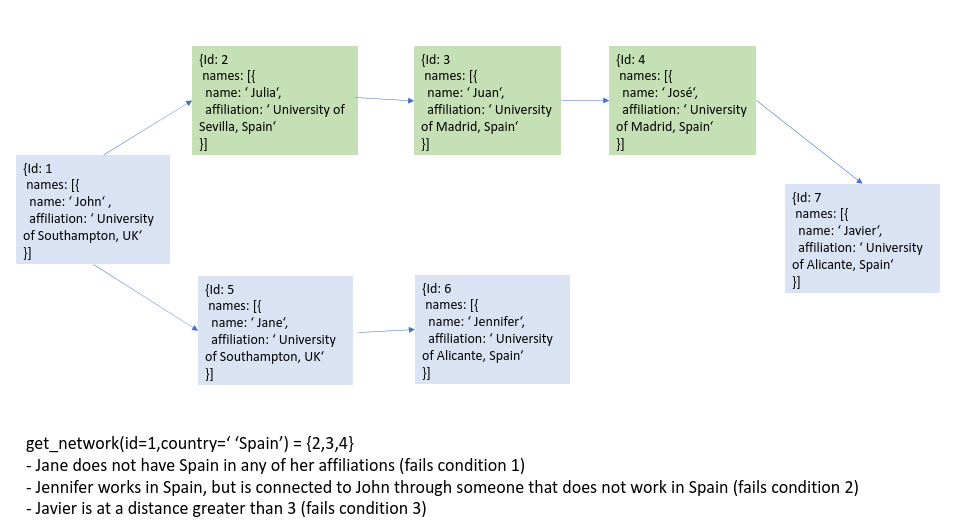


In [11]:

def get_network(authors,author_id,country):
    """
    Input: Authors collection, author_id, String country
    Output: List of ids of authors at three or less hops of distance with an affiliation that includes 'country'
    """
    
    m1 = {
        '$match': {
            '_id': author_id
        }
    }
    
    lookup = {
        '$graphLookup': {
            'from': "authors",
            'startWith': "$collaborators",
            'connectFromField': "collaborators",
            'connectToField': "_id",
            'as': "colabs",
            'restrictSearchWithMatch': { 
                "names_affiliations.affiliation" : {
                    '$regex': '.*' + country + '.*',
                    '$options': 'i'
                }
            },
            'maxDepth': 2
        }        
    }
    
    project= {
        '$project': {
            '_id': '$colabs._id'
        }
    }

    cursor = authors.aggregate([m1, lookup, project])
    
    lst = []
    for c in cursor:
        lst.extend(c['_id'])
    return lst

### 10)

The Management wants to know what articles are more important in the field of Machine Learning (look at the "fos" field for that). They know that papers in the references field may be from years previous to the ones in your dataset, so they would also like to know what is the most important paper within that subset published in each of the years you have in your dataset (2017,2018,2019). They want to use in-degree centrality as measure of importance.

Task:

Write a function that filters the subset of "Machine learning" articles and from it, compute the article with the highest in-degree centrality, both overall, and for articles published in each of the 2017, 2018 and 2019 years. 

Example output is provided as a comment in the function.


[10 points]


In [12]:

def machine_learning_central(articles):
    """
    Input: Articles collections.
    Output : {
       'overall' : (id_article_highest_indegree_centrality),
       '2017' : id_article_highest_indegree_centrality published year 2017,
       '2018' : id_article_highest_indegree_centrality published year 2018,
       '2019' : id_article_highest_indegree_centrality published year 2019,
    }
    In the case that for a given year, no article has been referenced (and thus, all centrality values are zero), 
    put None as the value of that year, example:
    {
       'overall' : id_article_highest_indegree_centrality,
       '2017' : id_article_highest_indegree_centrality of year 2017,
       '2018' : id_article_highest_indegree_centrality of year 2018,
       '2019' : None,
    }
    """
    
    m1 = {
        '$match': {
            "$and": [{
                'fos': { 
                    '$exists' : True
                } 
            }, {
                'references': { 
                    '$ne': None
                }
            }]
        }
    }
    
    u1 = {
        '$unwind': '$fos'
    }
    
    m2 = {
        '$match': {
            'fos.name': {
                '$regex': 'machine learning',
                '$options' : 'i'
            }
        }
    }
    
    g1 = {
        '$group': {
            '_id': '$year',
            'articleIdRef': {
                '$addToSet': { 
                    'id': '$id',
                    'references': '$references'
                }
            }
        }
    }
    
    u2 = {
        '$unwind': {
            'path': '$articleIdRef'
        }
    }
    
    u3 = {
        '$unwind': {
            'path': '$articleIdRef.references'
        }
    }

    p1 = {
        '$project': {
            '_id':0, 
            'year':'$_id', 
            'id' : '$articleIdRef.id', 
            'references' : '$articleIdRef.references'
        }
    }
    
    cursor = list(articles.aggregate([m1,u1,m2,g1,u2,u3,p1]))
    df = pd.DataFrame(cursor)
    
    finalDict = {}
    
    finalDict['overall'] = calculateInDegreeCentrality(df,'references','id')
    finalDict['2017'] = calculateInDegreeCentrality(df[df['year'] == 2017],'references','id')
    finalDict['2018'] = calculateInDegreeCentrality(df[df['year'] == 2018],'references','id')
    finalDict['2019'] = calculateInDegreeCentrality(df[df['year'] == 2019],'references','id')
    return finalDict

         
def calculateInDegreeCentrality(df,references,articleId):
    diGraph = nx.from_pandas_edgelist(df,source=articleId,target=references, edge_attr=True, create_using=nx.DiGraph())
    centralityDegree = nx.in_degree_centrality(diGraph)
    max_value = max(centralityDegree.values())
    max_key = [i for i in centralityDegree.keys() if centralityDegree[i]==max_value]
    
    return max_key[0]


## Task 2
This task will assess your ability to use the Hadoop Streaming API and MapReduce to process data. For each of the questions below, you are expected to write two python scripts, one for the Map phase and one for the Reduce phase. You are also expected to provide the correct parameters to the `hadoop` command to run the MapReduce process. Write down your answers in the specified cells below.

You will use the same dataset of articles that you used for task 1.

To help you, `%%writefile` has been added to the top of the cells, automatically writing them to "mapper.py" and "reducer.py" respectively when the cells are run.

No need to return a Python dictionary, the expected output here is the output file of Hadoop, named "output" for question1 and "output2" for question (do not change that part of the question)

### 1) 

Answer Question 2) of task 1 using the MapReduce paradigm (repeated below for your convenience)

Return the set of publishers of articles that are missing the doc_type property or have it equal to the empty string. 

[8 points]

In [13]:
%%writefile mapper.py
#!/usr/bin/env python
#Answer for mapper.py

import sys
import json

for line in sys.stdin:
    j = json.loads(line.strip())
    try:
        if j['doc_type'] == '':
            try:
                print(j['publisher'] + "\t1")
            except:
                print(j['pulisher'] + "\t1")
    except:
            try:
                print(j['publisher'] + "\t1")
            except:
                print(j['pulisher'] + "\t1")

Overwriting mapper.py


In [14]:
%%writefile reducer.py
#!/usr/bin/env python
# REDUCER

import sys
from collections import defaultdict

input_pairs = sys.stdin.readlines()

accumulator = set()
for row in input_pairs:
    
    key_value_pair = row.split("\t", 1)
    if len(key_value_pair) != 2:
        continue
    
    word = key_value_pair[0]

    accumulator.add(word.strip())
    
for word in accumulator:
    print(word)




Overwriting reducer.py


In [15]:
%%bash
#Hadoop command to run the map reduce.

hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
-files mapper.py,reducer.py \
-input ./articles.json \
-mapper ./mapper.py \
-reducer ./reducer.py \
-output output

21/12/16 00:39:24 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
21/12/16 00:39:24 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
21/12/16 00:39:24 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
21/12/16 00:39:24 INFO mapred.FileInputFormat: Total input files to process : 1
21/12/16 00:39:24 INFO mapreduce.JobSubmitter: number of splits:37
21/12/16 00:39:24 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local878872637_0001
21/12/16 00:39:25 INFO mapred.LocalDistributedCacheManager: Localized file:/home/comp6235/Mongodb/mapper.py as file:/tmp/hadoop-comp6235/mapred/local/1639615165125/mapper.py
21/12/16 00:39:25 INFO mapred.LocalDistributedCacheManager: Localized file:/home/comp6235/Mongodb/reducer.py as file:/tmp/hadoop-comp6235/mapred/local/1639615165126/reducer.py
21/12/16 00:39:25 INFO mapreduce.Job: The url to track the

limit_output extension: Maximum message size of 10000 exceeded with 150364 characters

In [16]:
#Expected output format, list of publishers, one per line
#Elsevier India
#Springer Cham
#UK Academy of Sciences
#....



### 2) 
Answer Question 5) of task 1 using the MapReduce paradigm (repeated below for your convenience)

Do longer articles (in number of pages) have more references?

Task:

Return an histogram dictionary with the following specification:

{
"1-5" : Average references of articles between 1 and 5 pages inclusive

"6-10" : Average references of articles between 6 and 10 pages inclusive

"11-15" : Average references of articles between 11 and 15 pages inclusive

"16-20" : Average references of articles between 16 and 20 pages inclusive

"21-25" : Average references of articles between 21 and 25 pages inclusive

"26-30" : Average references of articles between 26 and 30 pages inclusive

">30" : Average references of articles with more than 30 pages
}

A fellow data scientist of your team has found that some articles have no 'references' field, while others have unusually large page numbers. The Management decides that for this task you should

* Ignore articles that are missing the 'references' field
* Ignore articles with page numbers greater than 6 digits
* Ignore articles with page numbers that cannot be parsed to integers (e.g. 900467-12)

Clarifications:
*) Articles that start and end at the same page have 1 page, not zero!


[12 points]

In [17]:
%%writefile mapper2.py
#!/usr/bin/env python
#Answer for mapper.py

import sys
import json

for line in sys.stdin:
    j = json.loads(line.strip())
    try:
        pages = (int(j['page_end'].strip()) - int(j['page_start'].strip())) + 1
        if pages > 0 and pages < 6:
            print("1-5\t" + str(len(j['references'])))
        elif pages > 5 and pages < 11:
            print("6-10\t" + str(len(j['references'])))
        elif pages > 10 and pages < 16:
            print("11-15\t" + str(len(j['references'])))
        elif pages > 15 and pages < 21:
            print("16-20\t" + str(len(j['references'])))
        elif pages > 20 and pages < 26:
            print("21-25\t" + str(len(j['references'])))
        elif pages > 25 and pages < 31:
            print("26-30\t" + str(len(j['references'])))
        else:
            print(">30\t" + str(len(j['references'])))
    except:
        continue

Overwriting mapper2.py


In [18]:
%%writefile reducer2.py
#!/usr/bin/env python
# REDUCER

import sys
from collections import defaultdict

input_pairs = sys.stdin.readlines()

accumulator = defaultdict(lambda: 0)
accumulator2 = defaultdict(lambda: 0)

for row in input_pairs:
    
    key_value_pair = row.split("\t", 1)
    if len(key_value_pair) != 2:
        continue
    
    word = key_value_pair[0]
    if len(word.strip()) == 0:
        continue
    count = int(key_value_pair[1].strip())
    
    accumulator[word] = accumulator[word] + count
    accumulator2[word] += 1
    
for key in ["1-5", "6-10", "11-15", "16-20", "21-25", "26-30", ">30"]:
    accumulator[key] = round(accumulator[key]/accumulator2[key], 3)
    
for (key, value) in accumulator.items():
    print(key + "\t" + str(value))


Overwriting reducer2.py


In [19]:
%%bash
#Hadoop command to run the map reduce.

hadoop jar $HADOOP_HOME/share/hadoop/tools/lib/hadoop-streaming-*.jar \
-files mapper2.py,reducer2.py \
-input ./articles.json \
-mapper ./mapper2.py \
-reducer ./reducer2.py \
-output output2

21/12/16 00:40:14 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
21/12/16 00:40:14 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
21/12/16 00:40:14 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
21/12/16 00:40:14 INFO mapred.FileInputFormat: Total input files to process : 1
21/12/16 00:40:14 INFO mapreduce.JobSubmitter: number of splits:37
21/12/16 00:40:15 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_local1851107055_0001
21/12/16 00:40:15 INFO mapred.LocalDistributedCacheManager: Localized file:/home/comp6235/Mongodb/mapper2.py as file:/tmp/hadoop-comp6235/mapred/local/1639615215407/mapper2.py
21/12/16 00:40:15 INFO mapred.LocalDistributedCacheManager: Localized file:/home/comp6235/Mongodb/reducer2.py as file:/tmp/hadoop-comp6235/mapred/local/1639615215408/reducer2.py
21/12/16 00:40:16 INFO mapreduce.Job: The url to trac

limit_output extension: Maximum message size of 10000 exceeded with 152763 characters

In [20]:
#Expected key-value output format:
#1-5    average
#6-10   average
#... and so on

### Marking scheme

- The result provided is correct: An incorrect answer will have between 0% and 40% of the mark depending on the nature of the mistake. Questions where there was only one answer possible will have 0%, questions where the result is correct in some cases and not others will be marked at 20% or 40%. Feel free to create as many notebooks as you want for experimenting and transcribe your final answer to the one you submit.

- The result is provided in the expected format and output: 20% will be deducted to correct results that are not in the expected format

- Efficiency of the answer: Measured in terms of execution time. There are many ways to reach the correct result, some of them are more efficient than others, some are more straight forward than others. 

- Tables below detail the percentage of mark you get according to the efficiency of the answer, each cell shows the maximum time allowed to get the mark in the corresponding row. Answers that take more time than the time in the 60% column will be declared timeout and get zero points. (run the cells for showing the tables)





| Task1 | Points |  100% | 80% | 60% | 
| --- | --- | --- | --- | --- | 
| q1 | 5 | 5sec |  10 sec | 2minutes | 
|  q2 | 5 | 5sec   | 10 sec   | 2minutes   |
|  q3 | 5 |  10sec  | 40sec  |  5minutes  |
|  q4 | 5 | 5sec   | 10sec   | 2minutes   |
|  q5 | 10 | 10sec   | 60sec  | 8minutes   |
|  q6 | 10  |  15sec   | 90sec   | 10minutes   |
|  q7 | 10 | 15sec    | 90sec   | 10minutes   |
|  q8 | 10 | 90 sec    | 5minutes  | 10minutes  | 
|  q9 (worst case) | 10   | 20sec   |  100 sec  | 10 minutes  |
|  q10| 10  |  60sec  | 3minutes   | 10minutes   |

| Task2 | points | 100% | 80% | 60% | 
| --- |--- | --- | --- | --- | 
| q1 | 8 | 90sec |  5minutes | 10minutes | 
|  q2| 12  | 90sec   | 5minutes   | 10minutes   |